In [1]:
# using Revise
# path_to_package = "/home/manuel/.julia/dev/PauliPropagation"
# insert!(LOAD_PATH, 1, path_to_package);

# using Pkg
# Pkg.add(url="https://github.com/MSRudolph/PauliPropagation.jl.git", rev="dev")

In [2]:
using PauliPropagation
using Plots
using LinearAlgebra
using LaTeXStrings

In [3]:
θ = 0.1im

0.0 + 0.1im

In [4]:
# the computational basis matrices
rzmat = tomatrix(PauliRotation(:Z, 1), θ)
rxmat = tomatrix(PauliRotation(:X, 1), θ)
rzzmat = tomatrix(PauliRotation([:Z, :Z], [1, 2]), θ)

# the Pauli basis matrices
rzptm = calculateptm(rzmat; heisenberg=false)
rxptm = calculateptm(rxmat; heisenberg=false)
rzzptm = calculateptm(rzzmat; heisenberg=false)

# the Pauli basis transfermaps
rzmap = totransfermap(rzptm)
rxmap = totransfermap(rxptm)
rzzmap = totransfermap(rzzptm);

In [5]:
nq = 6
topology = bricklayertopology(nq)

# the circuit
circuit = Gate[]
append!(circuit, TransferMapGate(rxmap, ii) for ii in 1:nq);
# append!(circuit, TransferMapGate([ii], rzmap) for ii in 1:nq);
# append!(circuit, TransferMapGate(collect(pair), rzzmap) for pair in topology);

6-element Vector{Gate}:
 TransferMapGate{UInt8, Float64}(Vector{Tuple{UInt8, Float64}}[[(0x00, 1.0050041680558033), (0x01, 0.10016675001984401)], [(0x00, 0.10016675001984401), (0x01, 1.0050041680558033)], [(0x02, 1.0)], [(0x03, 1.0)]], [1])
 TransferMapGate{UInt8, Float64}(Vector{Tuple{UInt8, Float64}}[[(0x00, 1.0050041680558033), (0x01, 0.10016675001984401)], [(0x00, 0.10016675001984401), (0x01, 1.0050041680558033)], [(0x02, 1.0)], [(0x03, 1.0)]], [2])
 TransferMapGate{UInt8, Float64}(Vector{Tuple{UInt8, Float64}}[[(0x00, 1.0050041680558033), (0x01, 0.10016675001984401)], [(0x00, 0.10016675001984401), (0x01, 1.0050041680558033)], [(0x02, 1.0)], [(0x03, 1.0)]], [3])
 TransferMapGate{UInt8, Float64}(Vector{Tuple{UInt8, Float64}}[[(0x00, 1.0050041680558033), (0x01, 0.10016675001984401)], [(0x00, 0.10016675001984401), (0x01, 1.0050041680558033)], [(0x02, 1.0)], [(0x03, 1.0)]], [4])
 TransferMapGate{UInt8, Float64}(Vector{Tuple{UInt8, Float64}}[[(0x00, 1.0050041680558033), (0x01, 0.1001667

In [6]:
# # Manuel version

# nls = 1
# overlapsManuel = Float64[overlapwithplus(psum) / sqrt(2^nq)]
# for _ in 1:nls
#     psum = propagate!(circuit, psum)
#     @show psum
#     # @show norm(psum)
#     mult!(psum, 1/norm(psum))
#     push!(overlapsManuel, overlapwithplus(psum) / sqrt(2^nq))
# end

In [7]:
# Zoe Version

nls = 50

pstr = PauliString(nq, :I, 1)
psum = PauliSum(pstr)
beta = Float64[]

overlapsEnd = Float64[]
overlapsEvery = Float64[]

for i in 1:nls
    psum = propagate!(circuit, psum)
    #psumnew = mult!(psum, 1/((2^nq)*getcoeff(psum, :I, 1)))
    psumEvery = psum/(2^nq*getcoeff(psum, :I, 1))
    push!(overlapsEvery, overlapwithplus(psumEvery))
    push!(overlapsEnd, overlapwithplus(psum))
    push!(beta, 0.1*i)
end
overlapsEnd /= (2^nq*getcoeff(psum, :I, 1))


50-element Vector{Float64}:
 1.704605687273267e-13
 3.105994070033209e-13
 5.659490188908921e-13
 1.0312263473836576e-12
 1.8790169150257908e-12
 3.4237920471202643e-12
 6.238555857685322e-12
 1.136738991557476e-11
 2.0712734876538205e-11
 3.774106362604439e-11
 ⋮
 0.008227505625567327
 0.014991492680664867
 0.027316280659356134
 0.049773508546156336
 0.09069324568334908
 0.16525386802806524
 0.3011121797711892
 0.5486621637876496
 0.9997276437004122

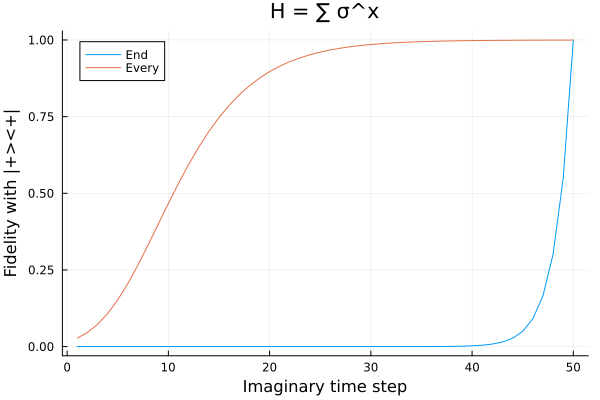

In [8]:
plot(overlapsEnd, ylabel="Fidelity with |+><+|", xlabel="Imaginary time step", label="End", title="H = ∑ σ^x")
plot!(overlapsEvery, ylabel="Fidelity with |+><+|", xlabel="Imaginary time step", label="Every", title="H = ∑ σ^x")


In [9]:
overlapsEnd2 = Float64[]
for j in 1:50
    pstr = PauliString(nq, :I, 1)
    psum = PauliSum(pstr)
    overlapsEndLoop = Float64[]
    for i in 1:j
        psum = propagate!(circuit, psum)
        push!(overlapsEndLoop, overlapwithplus(psum))
    end
    push!(overlapsEnd2, overlapsEndLoop[end]/(2^nq*getcoeff(psum, :I, 1)))
end


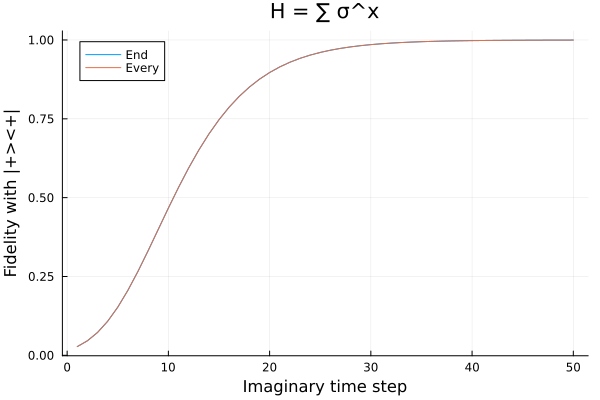

In [10]:
plot(overlapsEnd2, ylabel="Fidelity with |+><+|", xlabel="Imaginary time step", label="End", title="H = ∑ σ^x")
plot!(overlapsEvery, ylabel="Fidelity with |+><+|", xlabel="Imaginary time step", label="Every", title="H = ∑ σ^x")

In [11]:
function XMatrix(n::Int, i::Int)
    Xmat = [0 1; 1 0]
    Imat = [1 0; 0 1]

    operator = (i == 1) ? Xmat : Imat

    for j in 2:n
        if j == i
            operator = kron(operator, Xmat)
        else
            operator = kron(operator, Imat)
        end
    end
    
    return operator
end

function ZMatrix(n::Int, i::Int)
    Zmat = [1 0; 0 -1]
    Imat = [1 0; 0 1]

    operator = (i == 1) ? Zmat : Imat

    for j in 2:n
        if j == i
            operator = kron(operator, Zmat)
        else
            operator = kron(operator, Imat)
        end
    end
    
    return operator
end

ZMatrix (generic function with 1 method)

In [12]:
# function imaginaryTimeEvolution(nqubits::Int, h::Matrix, beta::Float64)
#     operator = exp(-beta/2*h)*I(2^nqubits)*exp(-beta/2*h)/(2^nqubits)
#     return operator/tr(exp(-beta*h))*(2^nqubits)
# end

function imaginaryTimeEvolution(nqubits::Int, h::Matrix, beta::Float64)
    operator = exp(-beta*h)
    return operator/tr(exp(-beta*h))
end

function imaginaryTimeEvolutionState(nqubits::Int, h::Matrix, beta::Float64, state::Vector)
    operator = exp(-beta*h)*state
    return operator/LinearAlgebra.norm(operator)
end

imaginaryTimeEvolutionState (generic function with 1 method)

In [13]:
#H = kron(XMatrix(1, 1),XMatrix(1, 1),XMatrix(1, 1))
nq = 6
H = I(2^nq)
for i in 1:nq
    H += XMatrix(nq, i)
end


In [14]:
state = [1; 1]/sqrt(2)
state = kron(state, state, state, state, state, state)

finalDensity = imaginaryTimeEvolution(nq, H, -100.0)
println(tr(finalDensity))
display(finalDensity)
println(state'*finalDensity*state)


64×64 Matrix{Float64}:
 0.015625  0.015625  0.015625  0.015625  …  0.015625  0.015625  0.015625
 0.015625  0.015625  0.015625  0.015625     0.015625  0.015625  0.015625
 0.015625  0.015625  0.015625  0.015625     0.015625  0.015625  0.015625
 0.015625  0.015625  0.015625  0.015625     0.015625  0.015625  0.015625
 0.015625  0.015625  0.015625  0.015625     0.015625  0.015625  0.015625
 0.015625  0.015625  0.015625  0.015625  …  0.015625  0.015625  0.015625
 0.015625  0.015625  0.015625  0.015625     0.015625  0.015625  0.015625
 0.015625  0.015625  0.015625  0.015625     0.015625  0.015625  0.015625
 0.015625  0.015625  0.015625  0.015625     0.015625  0.015625  0.015625
 0.015625  0.015625  0.015625  0.015625     0.015625  0.015625  0.015625
 ⋮                                       ⋱                      
 0.015625  0.015625  0.015625  0.015625  …  0.015625  0.015625  0.015625
 0.015625  0.015625  0.015625  0.015625     0.015625  0.015625  0.015625
 0.015625  0.015625  0.015625  0.015

1.0
0.9999999999999991


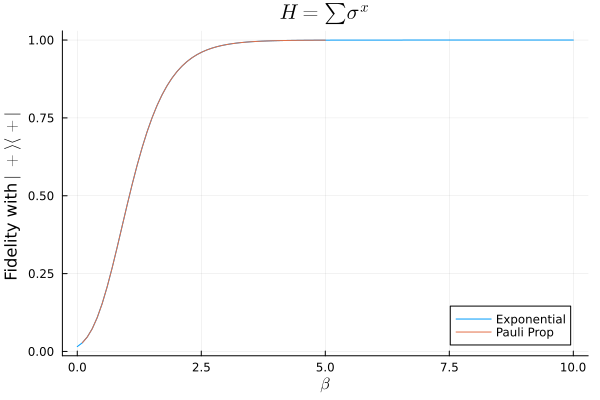

In [23]:
nq = 6
beta2 = LinRange(0, 10, 100)
overlap = Float64[]
for i in beta2
    density = imaginaryTimeEvolution(nq, H, -i)
    push!(overlap, state'*density*state)
end

plot(beta2, overlap, ylabel=L"Fidelity with $|+\rangle \leftangle+|$", xlabel=L"\beta",  label="Exponential", title=L"H = \sum \sigma^x")
plot!(beta, overlapsEvery, ylabel=L"Fidelity with $|+\rangle \leftangle+|$", xlabel=L"\beta", label="Pauli Prop", title=L"H = \sum \sigma^x")


In [20]:
nq = 10
topology = bricklayertopology(nq)

# the circuit
circuit = Gate[]
append!(circuit, TransferMapGate(rxmap, ii) for ii in 1:nq);
# append!(circuit, TransferMapGate([ii], rzmap) for ii in 1:nq);
# append!(circuit, TransferMapGate(collect(pair), rzzmap) for pair in topology);

10-element Vector{Gate}:
 TransferMapGate{UInt8, Float64}(Vector{Tuple{UInt8, Float64}}[[(0x00, 1.0050041680558033), (0x01, 0.10016675001984401)], [(0x00, 0.10016675001984401), (0x01, 1.0050041680558033)], [(0x02, 1.0)], [(0x03, 1.0)]], [1])
 TransferMapGate{UInt8, Float64}(Vector{Tuple{UInt8, Float64}}[[(0x00, 1.0050041680558033), (0x01, 0.10016675001984401)], [(0x00, 0.10016675001984401), (0x01, 1.0050041680558033)], [(0x02, 1.0)], [(0x03, 1.0)]], [2])
 TransferMapGate{UInt8, Float64}(Vector{Tuple{UInt8, Float64}}[[(0x00, 1.0050041680558033), (0x01, 0.10016675001984401)], [(0x00, 0.10016675001984401), (0x01, 1.0050041680558033)], [(0x02, 1.0)], [(0x03, 1.0)]], [3])
 TransferMapGate{UInt8, Float64}(Vector{Tuple{UInt8, Float64}}[[(0x00, 1.0050041680558033), (0x01, 0.10016675001984401)], [(0x00, 0.10016675001984401), (0x01, 1.0050041680558033)], [(0x02, 1.0)], [(0x03, 1.0)]], [4])
 TransferMapGate{UInt8, Float64}(Vector{Tuple{UInt8, Float64}}[[(0x00, 1.0050041680558033), (0x01, 0.100166

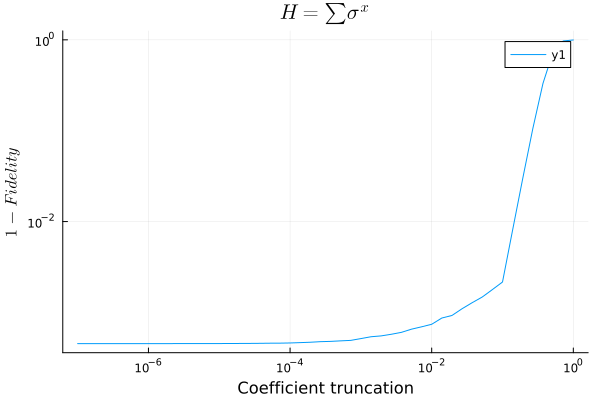

In [21]:
minCoeff = 10 .^ LinRange(-7, 0, 50)
overlap = Float64[]
nls = 50
nq = 10
pstr = PauliString(nq, :I, 1)
for i in minCoeff
    overlapLoop = Float64[]
    psum = PauliSum(pstr)
    for j in 1:nls
        psum = propagate!(circuit, psum; min_abs_coeff=i)
        psumEvery = psum/(2^nq*getcoeff(psum, :I, 1))
        push!(overlapLoop, overlapwithplus(psumEvery))
    end
    push!(overlap, overlapLoop[end])
end

plot(minCoeff, 1 .- overlap, ylabel=L"1-Fidelity", xlabel="Coefficient truncation", title=L"H = \sum \sigma^x",xscale=:log10, yscale=:log10)



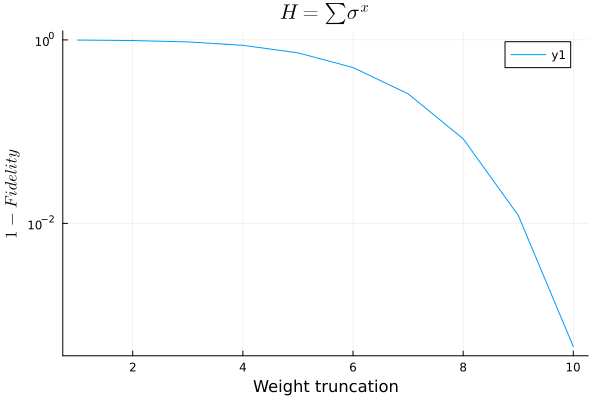

In [22]:
weightCoeff = (1:1:10)
overlap = Float64[]
nls = 50
nq = 10
pstr = PauliString(nq, :I, 1)
for i in weightCoeff
    overlapLoop = Float64[]
    psum = PauliSum(pstr)
    for j in 1:nls
        psum = propagate!(circuit, psum; max_weight = i)
        psumEvery = psum/(2^nq*getcoeff(psum, :I, 1))
        push!(overlapLoop, overlapwithplus(psumEvery))
    end
    push!(overlap, overlapLoop[end])
end

plot(weightCoeff, 1 .- overlap, ylabel=L"1-Fidelity", xlabel="Weight truncation", title=L"H = \sum \sigma^x", yscale=:log10)

In [ ]:
function computeTwoNorm(pstr::Vector, rho::Matrix, nq::Int)
    A = 0
    B = 1
    mix = 0
    for i in 1:size(pstr)[1]
        A += abs(pstr[i].coeff)^2
        string = (inttostring(pstr[i].term,nq))
        mix += pstr[i].coeff*tr(rho*interpretPauli(string))
    end
    A *= 2^nq
    return A+B-2*mix
end

function computeTwoNormTest(sigma::Matrix, rho::Matrix)
    A = tr(sigma*sigma)
    B = tr(rho*rho)
    mix = tr(sigma*rho)
        return A+B-2*mix
end

computeTwoNormTest (generic function with 2 methods)

In [29]:
computeTwoNormTest(state'*state,finalDensity)

2.220446049250313e-16